In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from lightgbm import LGBMClassifier

In [5]:
df = pd.read_csv('spaceship_titanic_dataset.csv')

In [6]:
df.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
5703,6039_02,Earth,False,F/1148/S,NaN,32.0,False,3.0,0.0,0.0,0.0,757.0,Myrace Powery,False
7850,8378_01,Earth,False,F/1608/S,TRAPPIST-1e,13.0,False,0.0,0.0,505.0,2810.0,9.0,Glena Bellyonsley,False
3508,3770_01,Earth,True,G/615/P,TRAPPIST-1e,16.0,False,0.0,0.0,0.0,NaN,0.0,Deandy Anthompson,True
7573,8092_03,Europa,False,D/238/S,TRAPPIST-1e,41.0,False,0.0,3216.0,0.0,433.0,517.0,Sterfik Pulgaly,False
3653,3927_01,Europa,False,C/142/S,55 Cancri e,38.0,False,55.0,1258.0,0.0,650.0,10786.0,Skyrmak Tionstious,False


'Transported' is the dependent variable, to be predicted

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [8]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

**Filling missing values**. Numerical features by mean and categorical by mode

In [9]:
# Separating numerical and categorical columns
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

In [10]:
df[numerical_features] = df[numerical_features].fillna(df[numerical_features].mean())
df[categorical_features]  = df[categorical_features].apply(lambda x: x.fillna(x.mode().iloc[0]))

/tmp/ipykernel_5718/147154473.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[categorical_features]  = df[categorical_features].apply(lambda x: x.fillna(x.mode().iloc[0]))


In [11]:
df.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [12]:
# Silly idea, but just to make sure if passengerid has any kind of relation with the output :D
# Splitting PassengerId
df[['pid1', 'pid2']] = df['PassengerId'].astype(str).str.split('_', expand=True)
df.drop('PassengerId', axis =1, inplace = True )
df.drop('Name', axis =1, inplace = True )

In [13]:
df.head(5)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,pid1,pid2
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,01
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,01
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,01
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,02
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,01


In [14]:
df['Transported'].value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

In [15]:
df['CryoSleep'].value_counts()

CryoSleep
False    5656
True     3037
Name: count, dtype: int64

In [16]:
df['Cabin'].value_counts()

Cabin
G/734/S     207
C/21/P        7
B/201/P       7
G/1368/P      7
E/13/S        7
           ... 
G/556/P       1
E/231/S       1
G/545/S       1
G/543/S       1
F/947/P       1
Name: count, Length: 6560, dtype: int64

In [17]:
# Splitting 'cabin' feature
df[['c1', 'c2', 'c3']] = df['Cabin'].str.split('/', expand=True)

In [18]:
df.drop('Cabin', axis =1, inplace = True )

In [19]:
df['HomePlanet'].value_counts()

HomePlanet
Earth     4803
Europa    2131
Mars      1759
Name: count, dtype: int64

In [20]:
df['Destination'].value_counts()

Destination
TRAPPIST-1e      6097
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

In [21]:
df.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,pid1,pid2,c1,c2,c3
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,01,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,01,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,01,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,02,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,01,F,1,S


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Destination   8693 non-null   object 
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   bool   
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   bool   
 11  pid1          8693 non-null   object 
 12  pid2          8693 non-null   object 
 13  c1            8693 non-null   object 
 14  c2            8693 non-null   object 
 15  c3            8693 non-null   object 
dtypes: bool(3), float64(6), object(7)
memory usage: 908.5+ KB


***Label Encoding***

In [23]:
label_encoder = LabelEncoder()
columns_to_encode = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Transported', 'pid1', 'pid2', 'c1', 'c2', 'c3']
df[columns_to_encode] = df[columns_to_encode].apply(lambda col: label_encoder.fit_transform(col))

In [25]:
df.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,pid1,pid2,c1,c2,c3
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1,1,0,5,0,1
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,2,0,0,0,1
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,2,1,0,0,1
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1,3,0,5,1,1


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   int64  
 1   CryoSleep     8693 non-null   int64  
 2   Destination   8693 non-null   int64  
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   int64  
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   int64  
 11  pid1          8693 non-null   int64  
 12  pid2          8693 non-null   int64  
 13  c1            8693 non-null   int64  
 14  c2            8693 non-null   int64  
 15  c3            8693 non-null   int64  
dtypes: float64(6), int64(10)
memory usage: 1.1 MB


**Finding correlation with output feature**

In [29]:
print(df.corrwith(df['Transported']).sort_values(ascending=False))

Transported     1.000000
CryoSleep       0.460132
HomePlanet      0.115461
c3              0.101397
pid2            0.066390
FoodCourt       0.046074
pid1            0.021825
c2              0.019393
ShoppingMall    0.010019
VIP            -0.037261
Age            -0.074249
Destination    -0.108152
c1             -0.113992
VRDeck         -0.204825
Spa            -0.218791
RoomService    -0.242048
dtype: float64


**Histogram**

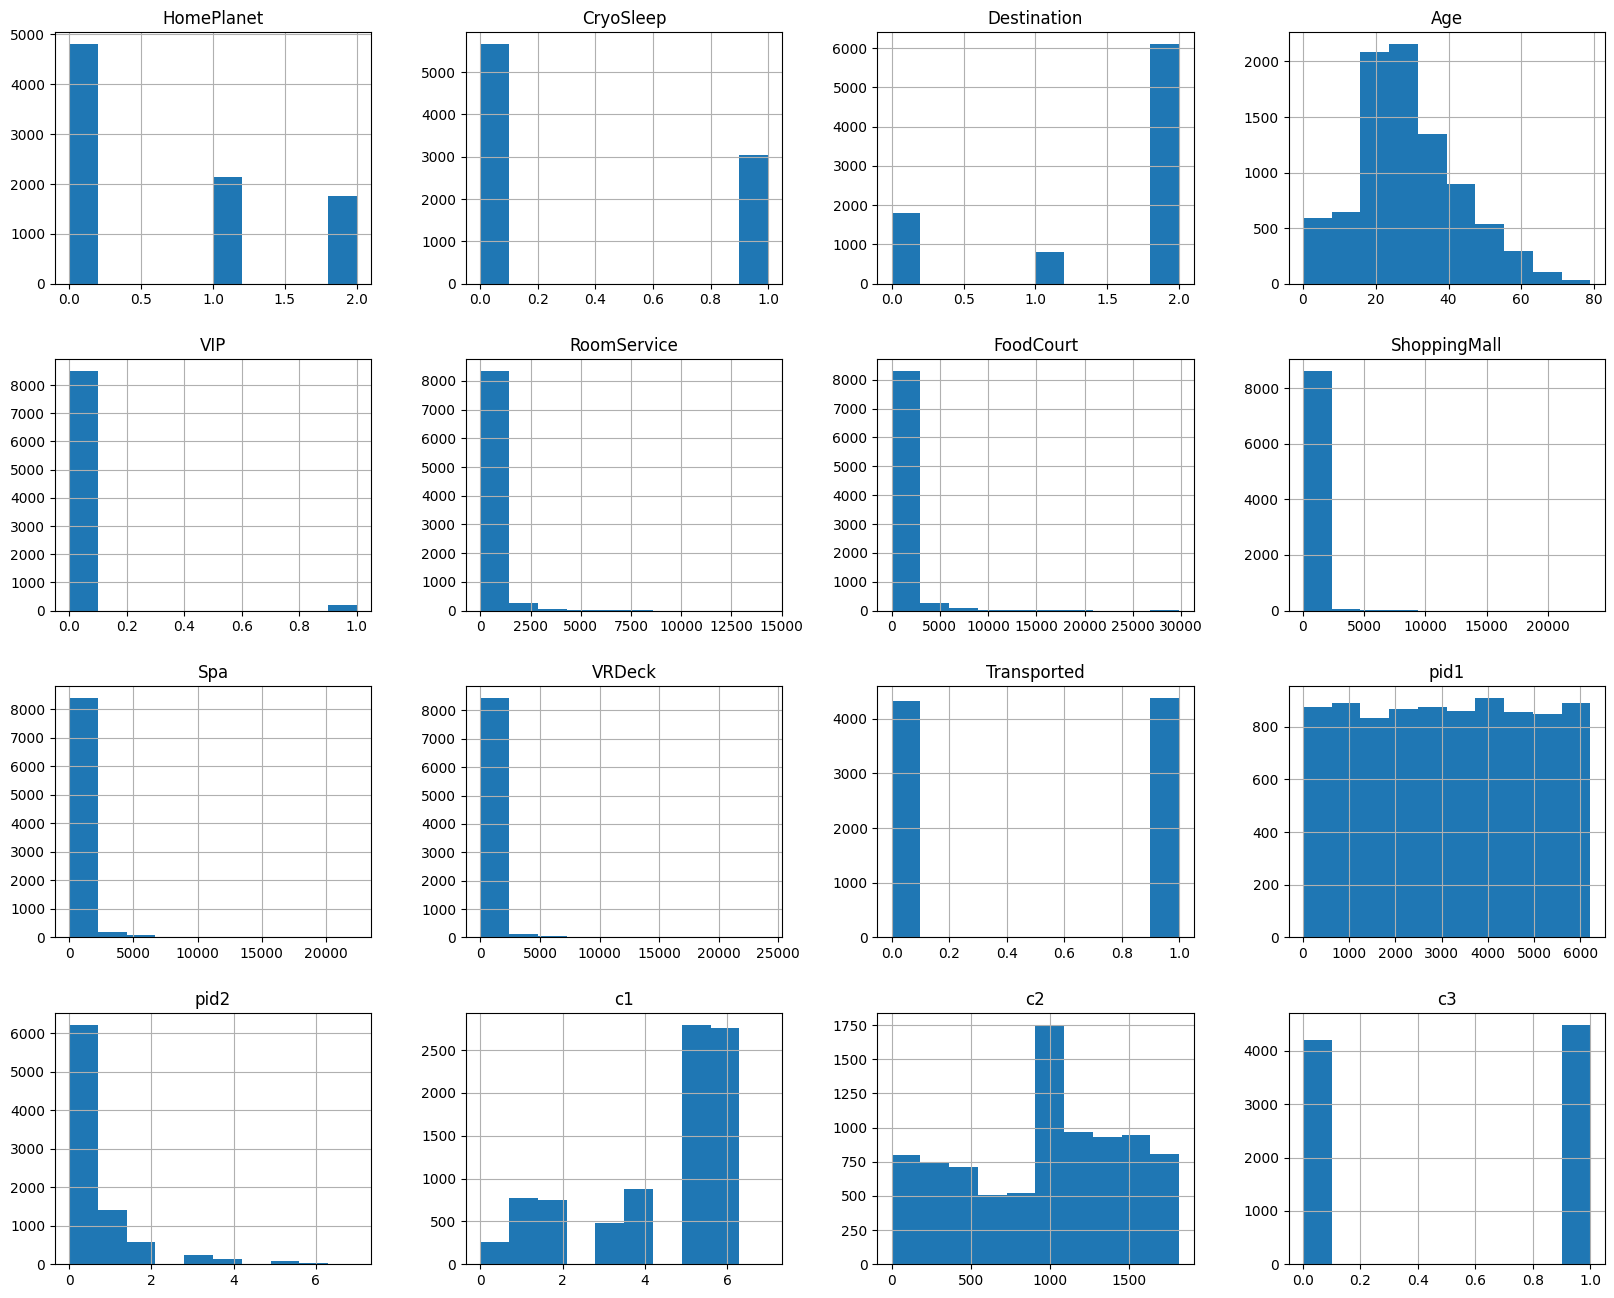

In [30]:
df.hist(figsize = (20,16))
plt.show()

In [31]:
X = df.drop('Transported', axis =1 )
y = df['Transported']

**BoxPlot**

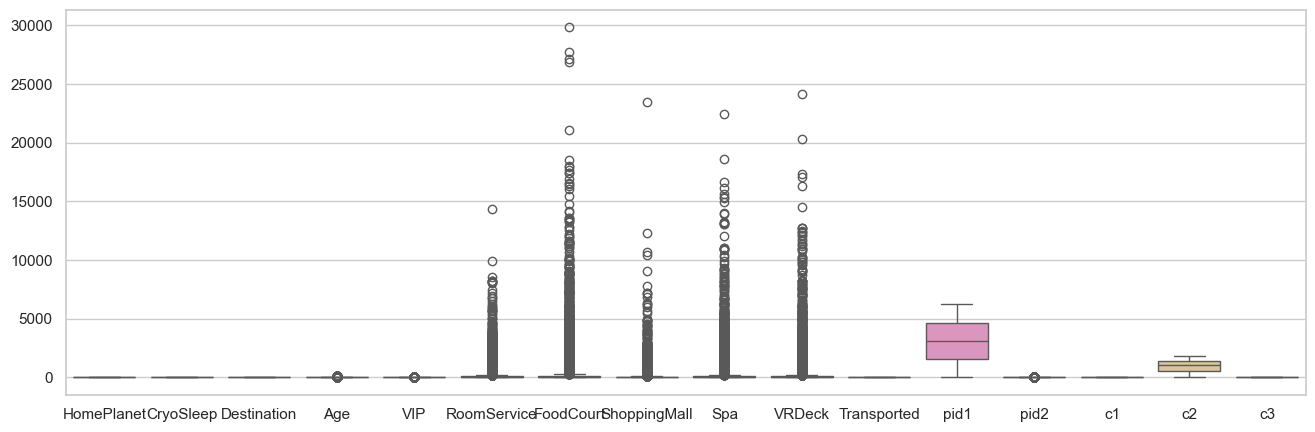

In [32]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 5))
sns.boxplot(data=df, palette="Set2")
plt.show()

**Train Test split**

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Scaling data**

In [34]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


**Time to train some popular ML models**

In [35]:
# Initialize the classifiers
rf_classifier = RandomForestClassifier(random_state=42)
gb_classifier = GradientBoostingClassifier(random_state=42)
ada_classifier = AdaBoostClassifier(random_state=42)
svm_classifier = SVC(random_state=42)
xgb_classifier = XGBClassifier(random_state=42)

# List of classifiers
classifiers = [rf_classifier, gb_classifier, ada_classifier, svm_classifier, xgb_classifier]

# Train and evaluate each classifier
for classifier in classifiers:
    # Train the model
    classifier.fit(X_train_scaled, y_train)
    
    # Predict on the test set
    y_pred = classifier.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Display the accuracy for each classifier
    print(f"{classifier.__class__.__name__} Accuracy: {accuracy:.4f}")


RandomForestClassifier Accuracy: 0.7918
GradientBoostingClassifier Accuracy: 0.7924


/home/nrdelementary/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier Accuracy: 0.7740
SVC Accuracy: 0.7982
XGBClassifier Accuracy: 0.7849


**Let's train ANN model**

In [36]:
from keras.layers import Dropout, BatchNormalization

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2048      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [38]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=2)

Epoch 1/20
87/87 - 4s - loss: 3.4930 - accuracy: 0.4954 - val_loss: 3.0272 - val_accuracy: 0.5701 - 4s/epoch - 49ms/step
Epoch 2/20
87/87 - 0s - loss: 2.9579 - accuracy: 0.5289 - val_loss: 2.6497 - val_accuracy: 0.5622 - 447ms/epoch - 5ms/step
Epoch 3/20
87/87 - 0s - loss: 2.5523 - accuracy: 0.5529 - val_loss: 2.3117 - val_accuracy: 0.5960 - 447ms/epoch - 5ms/step
Epoch 4/20
87/87 - 0s - loss: 2.2062 - accuracy: 0.5792 - val_loss: 2.0094 - val_accuracy: 0.6139 - 437ms/epoch - 5ms/step
Epoch 5/20
87/87 - 0s - loss: 1.9049 - accuracy: 0.6193 - val_loss: 1.7313 - val_accuracy: 0.6729 - 441ms/epoch - 5ms/step
Epoch 6/20
87/87 - 0s - loss: 1.6369 - accuracy: 0.6559 - val_loss: 1.4773 - val_accuracy: 0.7707 - 443ms/epoch - 5ms/step
Epoch 7/20
87/87 - 0s - loss: 1.4263 - accuracy: 0.6890 - val_loss: 1.2820 - val_accuracy: 0.7901 - 439ms/epoch - 5ms/step
Epoch 8/20
87/87 - 0s - loss: 1.2351 - accuracy: 0.7203 - val_loss: 1.1047 - val_accuracy: 0.7937 - 441ms/epoch - 5ms/step
Epoch 9/20
87/87 -

**Let's train LGBM classifer**

In [40]:
lgb_classifier = LGBMClassifier()
lgb_classifier.fit(X_train, y_train)
y_pred = lgb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1892
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
Accuracy: 0.8056


**Hyperparameter Tuning**

In [53]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'num_leaves': [15, 31, 63],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [20, 30, 40],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
}

In [55]:
grid_search = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid, cv=3, scoring='accuracy')

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

In [ ]:
best_lgb_classifier = LGBMClassifier(**best_params)

In [ ]:
best_lgb_classifier.fit(X_train, y_train)

In [ ]:
y_pred = best_lgb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on Test Set: {accuracy:.4f}')